# W207 Final Project: Baseline - TalkingData AdTracking Fraud Detection

**Team:** Samantha Williams, Vincent Goldberg and Heaven Klair


## **Introduction:** 
The [Kaggle competition](https://www.kaggle.com/competitions/talkingdata-adtracking-fraud-detection/overview) we have choosen was designed to find an algorithm for TalkingData that would best predict an app download after a mobile advertisement click is made. 

As China’s largest data service platform, TalkingData covers more than 70% of all active mobile devices and processes 3 billion clicks daily with an estimated 90% of those clicks considered fraudulent. 

This was TalkingData’s second Kaggle competition and provided users with a dataset with 200 million clicks over 4 days.

The problem that we are asked to solve is a predictive one: After clicking the ad with the user download the app? 


## **Step 1:** Import Libraries & Data

In [ ]:
!pip install opendatasets --quiet
!pip install scikit-learn==1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 28.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [ ]:
# We will import every library needed for this project. 
import os
import time

#importing data
import opendatasets as od

#Data processing
import numpy as np
import pandas as pd
# from pandas.core.arrays.datetimes import time
# from dython.nominal import associations

#Data visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

#ML processing 
import tensorflow as tf 
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

###Download Data
We will import all the availble data sets directly from Kaggle using an API key generated through our Kaggle account. Additional details for accessing and downloading these data file can be found in the json file.

In [ ]:
#download the data sets from Kaggle directly 
#This will take approx 2 minutes and 10 seconds

#username: swllmsberkeley
#key: ea2c9237a51cd10c6ad36b17c9215c47

od.download(
    'https://www.kaggle.com/competitions/talkingdata-adtracking-fraud-detection/data?select=train_sample.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: swllmsberkeley
Your Kaggle Key: ··········


100%|██████████| 1.94G/1.94G [00:10<00:00, 206MB/s]



Extracting archive ./talkingdata-adtracking-fraud-detection/talkingdata-adtracking-fraud-detection.zip to ./talkingdata-adtracking-fraud-detection


### Loading Sample Training Set
While we would love to load in the full training and test set, we just do not have enough RAM to make this happen in one go. We will need to work with the data in batches. For our intial inspection of the data, we will be working with the training sample provided that contains 100,000 rows.

In [ ]:
#set the dtypes for the data set that we know based on the compeition details provided. 
#The following features are all categorical: ip, app, device, os and channel. 
#However we set the types of data for the variables to int because 
#it is faster to separate the datasets into days (Something we will need for later).

dtypes = {
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'click_time': 'str',
    'attributed_time': 'str',
    'is_attributed': 'uint8'
}

#we have commented this code out for now as we ended up creating our own data set.
##read in the train sample data set 
train_sample = pd.read_csv('/content/talkingdata-adtracking-fraud-detection/train_sample.csv', dtype=dtypes)


###Loading in Test Set

In [ ]:
#read in the test data set 
test = pd.read_csv('/content/talkingdata-adtracking-fraud-detection/test.csv', dtype=dtypes)

NameError: ignored

###Creating A Balanced Data Set
The majority of records in the sample training set provided by TalkingData indicate that no app was downloaded. Upon further inspection we see that the training set is heavily unbalanced. To assist in creating a better model and to better maximize our resourse (RAM) we have created a balanced data set that includes all the instances of when the app was downloaded from the entire training set and have downsampled records where no app was downloaded. 

####Extracting Day 1 Rows


In [ ]:
# set up empty dataframe to store rows from the first day
df_first_day = pd.DataFrame()

# set the start and end dates as strings
start_date = pd.to_datetime('2017-11-06 0:0:0')
end_date = pd.to_datetime('2017-11-06 23:59:59')

# convert start and end dates to Timestamp objects
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# define chunksize and dtypes
chunksize = 10 ** 6


# loop over the chunks in the csv file
for chunk in pd.read_csv('/content/talkingdata-adtracking-fraud-detection/train.csv', chunksize=chunksize, dtype=dtypes, parse_dates=['click_time', 'attributed_time']):
    # filter for rows in the first day
    filtered_chunk = chunk[(chunk['click_time'] >= start_date) & (chunk['click_time'] < end_date)]
    # append filtered chunk to df_first_day
    df_first_day = pd.concat([df_first_day, filtered_chunk], ignore_index=True)
    # break the loop if the last click_time date in the chunk is greater than or equal to end_date
    if chunk.iloc[-1]['click_time'] >= end_date:
        break
        
df_first_day = df_first_day[df_first_day['is_attributed'] == 0]

In [ ]:
len(df_first_day) # should get 9290407 rows

9290407

####Extracting Day 2 Rows

In [ ]:
# define start and end dates for the second day
start_date_2 = '2017-11-07'
end_date_2 = pd.to_datetime('2017-11-07 23:59:59')

start_date = pd.to_datetime(start_date_2)
end_date = pd.to_datetime(end_date_2)

# set up empty dataframe to store data for second day
df_second_day = pd.DataFrame()

# set up loop to read the data in chunks and extract rows for the second day
for chunk in pd.read_csv('/content/talkingdata-adtracking-fraud-detection/train.csv', chunksize=chunksize, dtype=dtypes, parse_dates=['click_time', 'attributed_time']):
    # filter rows for the second day
    filtered = chunk[(chunk['click_time'] >= start_date_2) & (chunk['click_time'] <= end_date_2)]
    # add filtered rows to the dataframe for the second day
    df_second_day = pd.concat([df_second_day, filtered], ignore_index=True)
    # break the loop if the last click_time date in the chunk is greater than or equal to end_date_2
    if chunk.iloc[-1]['click_time'] >= end_date_2:
        break

df_second_day = df_second_day[df_second_day['is_attributed'] == 0]


In [ ]:
len(df_second_day) 

59481146

#### Extracting Day 3 Rows

In [ ]:
# define start and end dates for the third day
start_date_3 = '2017-11-08'
end_date_3 = pd.to_datetime('2017-11-08 23:59:59')

start_date = pd.to_datetime(start_date_3)
end_date = pd.to_datetime(end_date_3)

# set up empty dataframe to store data for third day
df_third_day = pd.DataFrame()

# set up loop to read the data in chunks and extract rows for the third day
for chunk in pd.read_csv('/content/talkingdata-adtracking-fraud-detection/train.csv', chunksize=chunksize, dtype=dtypes, parse_dates=['click_time', 'attributed_time']):
    # filter rows for the third day
    filtered = chunk[(chunk['click_time'] >= start_date_3) & (chunk['click_time'] <= end_date_3)]
    # add filtered rows to the dataframe for the third day
    df_third_day = pd.concat([df_third_day, filtered], ignore_index=True)
    # break the loop if the last click_time date in the chunk is greater than or equal to end_date_3
    if chunk.iloc[-1]['click_time'] >= end_date_3:
        break
  
df_third_day = df_third_day[df_third_day['is_attributed'] == 0]


In [ ]:
len(df_third_day)

62791754

####Extracting Day 4 Rows

In [ ]:
# define start and end dates for the fourth day
start_date_4 = '2017-11-09'
end_date_4 = pd.to_datetime('2017-11-09 23:59:59')

start_date = pd.to_datetime(start_date_4)
end_date = pd.to_datetime(end_date_4)

# set up empty dataframe to store data for fourth day
df_fourth_day = pd.DataFrame()

# set up loop to read the data in chunks and extract rows for the fourth day
for chunk in pd.read_csv('/content/talkingdata-adtracking-fraud-detection/train.csv', chunksize=chunksize, dtype=dtypes, parse_dates=['click_time', 'attributed_time']):
    # filter rows for the fourth day
    filtered = chunk[(chunk['click_time'] >= start_date_4) & (chunk['click_time'] <= end_date_4)]
    # add filtered rows to the dataframe for the fourth day
    df_fourth_day = pd.concat([df_fourth_day, filtered], ignore_index=True)
    # break the loop if the last click_time date in the chunk is greater than or equal to end_date_4
    if chunk.iloc[-1]['click_time'] >= end_date_4:
        break

df_fourth_day = df_fourth_day[df_fourth_day['is_attributed'] == 0]


In [ ]:
len(df_fourth_day)

52882970

####Merge Each Day Into Dataset 
We will merge each day into onde dataset according to their proportion of records. 

In [ ]:
prop_day1 = 9290407 / 190000000
prop_day2 = 59481146 / 190000000
prop_day3 = 62791754 / 190000000
prop_day4 = 52882970 / 190000000

# Calculate the number of rows to sample from each day by multiplying the proportion 
# with the desired total number of rows
num_sample_day1 = int(500000 * prop_day1)
num_sample_day2 = int(500000 * prop_day2)
num_sample_day3 = int(500000 * prop_day3)
num_sample_day4 = int(500000 * prop_day4)

In [ ]:
# sample the desired number of rows from each day's data frame
sample_day1 = df_first_day.sample(num_sample_day1) 
sample_day2 = df_second_day.sample(num_sample_day2)
sample_day3 = df_third_day.sample(num_sample_day3)
sample_day4 = df_fourth_day.sample(num_sample_day4)

In [ ]:
df_no_app_download = pd.concat([sample_day1, sample_day2, sample_day3, sample_day4]) 

In [ ]:
len(df_no_app_download)

485383

This graph matches with the trends of the train_sample dataset for records where no app was downloaded. This gives us a strong indication of randomness of the data we generated from the full training set. 

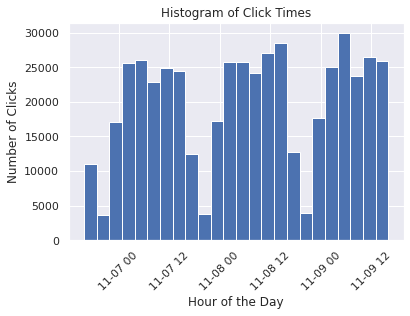

In [ ]:
plt.hist(df_no_app_download['click_time'], bins=24)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Clicks')
plt.title('Histogram of Click Times')
plt.xticks(rotation=45) 
plt.show()

####Extracting Data When The App Was Downloaded

Creating a dataset of records from the full training set where the app was downloaded.

In [ ]:
#This takes around 2 mintues to execute to completion 
train_dlapp = pd.DataFrame()
chunksize = 10**6

#in each chunk, filter for values that have 'is_attributed'==1, and merge these values into one dataframe
for chunk in pd.read_csv('/content/talkingdata-adtracking-fraud-detection/train.csv', chunksize=chunksize, dtype=dtypes):
    filtered = (chunk[(np.where(chunk['is_attributed']==1, True, False))])
    train_dlapp = pd.concat([train_dlapp, filtered], ignore_index=True, )


In [ ]:
#Sanity Check that this worked
train_dlapp.info()
print(len(train_dlapp))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456846 entries, 0 to 456845
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               456846 non-null  uint32
 1   app              456846 non-null  uint16
 2   device           456846 non-null  uint16
 3   os               456846 non-null  uint16
 4   channel          456846 non-null  uint16
 5   click_time       456846 non-null  object
 6   attributed_time  456846 non-null  object
 7   is_attributed    456846 non-null  uint8 
dtypes: object(2), uint16(4), uint32(1), uint8(1)
memory usage: 12.6+ MB
456846


####Storing Final Dataset

Storing the final dataset as a CSV file in the datasets folder

In [ ]:
final_train_dataset = pd.concat([df_no_app_download, train_dlapp], ignore_index=True)


In [ ]:
# specify file path and name
# file_path = os.path.join('/content/talkingdata-adtracking-fraud-detection/', 'final_train_dataset.csv')

# write dataframe to csv file
# final_df.to_csv(index=False)

In [ ]:
len(final_train_dataset)

942229

####Uploading Balanced Training Set

In [ ]:
#uploading Dataset for now; we can delete this later 

train_bal = pd.read_csv('/content/final_training_sample.csv')
train_bal.info()

FileNotFoundError: ignored

## **Step 2:** Initial Inspection of Data

For reference, TalkingData has provided details about the information contatined in the data set. Each row of the training data contains a click record, with the following features. Note that ip, app, device, os, and channel are encoded and the actual value it corresponds to is unknown. Additionally, the columns click_time and attributed_time are objects that will need to be converted to a data/time format that is useable for our analysis.

*   **ip:** ip address of click
*   **app:** app id for marketing
*   **device:** device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
*   **os:** os version id of user mobile phone
*   **channel:** channel id of mobile ad publisher
*   **click_time:** timestamp of click (UTC)
*   **attributed_time:** if user download the app for after clicking an ad, this is the time of the app download
*   **is_attributed:** the target that is to be predicted, indicating the app was downloaded

The test data is similar, with the following differences:
*   **click_id:** reference for making predictions
*   **is_attributed:** not included in the data set


###Training Sample: Inspection and Adjustments of the Data

In [ ]:
#Change click_time and attribuited_time from object to time
train_sample['click_time'] = pd.to_datetime(train_sample['click_time'])
train_sample['attributed_time'] = pd.to_datetime(train_sample['attributed_time'])

print('Sample Training Set:')
train_sample.info()

In [ ]:
#checking the train sample table
train_sample.head()

There are some NaT values in the attribuited time. Based on the explanation of this feature, it would imply that the person clicked on the ad but never downloaded the app. These are wherw would expect to find NaT values. Upon further analysis we have discovered that this is a fairly clean data set.  

In [ ]:
#Looking for null values in places we do not expect
print(train_sample.isnull().sum())

In [ ]:
#Looking at descriptive statistics for the train sample data set
#Only 227 instances where the app was downloaded in the sample data set 
#there are 161 apps and 161 channels
#Only 34,857 unique ip address out of 100,000
  #Mulitple clicks on the link before download? 
#We have a heavily imbalanced data set 

train_sample.describe(include='all', datetime_is_numeric=True)

###Balanced Training Set: Inspection and Adjustments of the Data

In [ ]:
#Change click_time and attribuited_time from object to time
train_bal['click_time'] = pd.to_datetime(train_bal['click_time'])
train_bal['attributed_time'] = pd.to_datetime(train_bal['attributed_time'])

print('Balanced Training Set:')
train_bal.info()

In [ ]:
#checking the train sample table
train_bal.head()

###Test Set: Inspection and Adjustments of Data


In [ ]:
test['click_time'] = pd.to_datetime(test['click_time'])
test['hour'] = test['click_time'].dt.hour 
test['day'] = test['click_time'].dt.day

## **Step 3:** Visual Data Exploration

###Training Sample Visualizations

Visual explortation of the sample training set provided by TalkingData. 

####Histogram of Click Times

In [ ]:
plt.hist(train_sample['click_time'], bins=24)
plt.xlabel('Hour of the Day') 
plt.ylabel('Number of Clicks')
plt.title('Histogram of Click Times')
plt.xticks(rotation=45) 
plt.show()

####Boxplot of Click Times for All Variables

In [ ]:
# Plot a boxplot of the click time for all variables (this doesn't seem right. Need more investigation)
train_sample.boxplot()
plt.title('Box Plot of Click Times')
plt.ylabel('Click Time')

plt.show()

####Correlation Matrix

In [ ]:
corr = train_sample.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Heatmap of Correlation between Continuous Variables')
plt.show()

**Heaven's takeway from the corr matrix:** All the values are pretty small except from correlation between `os` and `device` which makes sense since an operating system of a device is highly dependent upon the device a person is using. If we were to do feature engineering, we can drop one of these variables. Decide upon discussion. 

####Pairplots

In [ ]:
sns.pairplot(train_sample[['click_time', 'app', 'device', 'os', 'channel', 'ip']])
plt.title('Pair Plot of Click Time, App, Device, OS, Channel, and IP')
plt.show()

####Plot of Click By Hour

In [ ]:
# Extract hour and day information from click_time (inclusive of all 4 days)
# We can do the same for each day as well (haven't written the code yet)
train_sample['hour'] = train_sample['click_time'].dt.hour 
train_sample['day'] = train_sample['click_time'].dt.day

# Plot the distribution of clicks by hour
hour_counts = train_sample['hour'].value_counts().sort_index()
plt.bar(hour_counts.index, hour_counts.values)
plt.xlabel('Hour of Day')
plt.ylabel('Click Count')
plt.title('Clicks by Hour')
plt.show()

####Plot of Clicks By Days

In [ ]:
# Plot the distribution of clicks by day (there are only 4 days)
day_counts = train_sample['day'].value_counts().sort_index()
plt.bar(day_counts.index, day_counts.values)
plt.xlabel('Day of Month')
plt.ylabel('Click Count')
plt.title('Clicks by Day')
plt.show()

####How Balanced is Training Sample
This data is not balanced at all and is what led us to creating a balanced data set to work with. 

In [ ]:
#Create a function that we will use again for other count plots.
def boxplot_figures(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

In [ ]:
plt.figure(figsize= (7,5))
ax = sns.countplot('is_attributed', data = train_sample)
plt.title('No Download Compared to App Download After Click')
plt.xlabel('No App Download (0) vs App Downloaded (1)')
plt.ylabel('Count')

boxplot_figures(ax, train_sample.is_attributed)

###Balanced Training Set Visualizations

Some of these are a sanity check of our balanced training data set as compared to the training sample set. 

####How Balanced is Training Set

In [ ]:
plt.figure(figsize= (7,5))
ax = sns.countplot('is_attributed', data = train_bal)
plt.title('No Download Compared to App Download After Click')
plt.xlabel('No App Download (0) vs App Downloaded (1)')
plt.ylabel('Count')

boxplot_figures(ax, train_bal.is_attributed)

####Histogram of Click Times

In [ ]:
plt.hist(train_bal['click_time'], bins=24)
plt.xlabel('Hour of the Day') 
plt.ylabel('Number of Clicks')
plt.title('Histogram of Click Times')
plt.xticks(rotation=45) 
plt.show()

####Boxplot of Click Times for All Variables 

In [ ]:
# Plot a boxplot of the click time for all variables (this doesn't seem right. Need more investigation)
train_bal.boxplot()
plt.title('Box Plot of Click Times')
plt.ylabel('Click Time')

plt.show()

####Histogram of Time Delay

In [ ]:
# calculate the time elapsed between click and attribution, in hours
time_delay = (train_bal['attributed_time'] - train_bal['click_time']).dt.total_seconds() / 3600

# create a histogram of the time delay
plt.hist(time_delay, bins=50)

# add labels and title
plt.xlabel('Time Delay (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Time Delay between Click and Attribution')

# display the plot
plt.show()


## **Step 4:** Feature Engineering 

In [ ]:
#ideas for additional feature engineering
  #clicks per ip
  #clicks per app/channel (These seem to be the same)
  #clicks per hour
  #clicks per os
  #clicks per device
  #clicks by app & device
  #clicks by app & ip
  #clicks by app & os

###Time (Seconds) After Click App Downloaded

In [ ]:
train_bal['sec_till_dl'] = (train_bal['attributed_time'] - train_bal['click_time']).dt.total_seconds() / 3600

###Account for all NaN/Nat values


In [ ]:
train_bal['attributed_time'] = train_bal['attributed_time'].fillna(pd.Timedelta(seconds=0))

number of clicks on ad before download (groupby: ip, device, chan, os)

Hour of the day


## **Step 5:** Baseline Models



Although the final test data set consist of values indicating the probability a user will download an app, the train data set uses a binary classifier to indicate whether a user downloaded the app. A value of 1 is assigned to the clicks that led to a download, while a value of 0 indicates a click did not lead to a download. Due to the nature of the binary classification, a logistic regression model was selected to be the baseline model evaluation. 

In [ ]:
dtypes = {
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'click_time': 'str',
    'attributed_time': 'str',
    'is_attributed': 'uint8'
}

training_data = pd.read_csv('/content/final_training_sample.csv', dtype=dtypes)

In [ ]:
# splitting feature and variables

train = training_data.iloc[:, 2:6]
labels = training_data.iloc[:, -1]

###Logistic Regression using SGD

In [ ]:
# splitting train and test data
enc = OneHotEncoder(handle_unknown='ignore')
enc_train = enc.fit_transform(train)
print(enc_train.shape, labels.shape)

lr_x_train, lr_x_test, lr_y_train, lr_y_test = train_test_split(enc_train, labels, test_size=0.2,  random_state=42)

print(lr_x_train.shape, lr_y_train.shape)
print(lr_x_test.shape, lr_y_test.shape)

In [ ]:
## creating logistic regression model with stochastic gradient descent (SGD) learning

model = SGDClassifier(loss='log_loss', validation_fraction=0.2).fit(lr_x_train, lr_y_train)
val_scores = cross_val_score(model, lr_x_train, lr_y_train)

In [ ]:
## Making prediction off model
lr_y_pred = model.predict(lr_x_train)
lr_y_pred_prob = model.predict_proba(lr_x_train)
accuracy = model.score(lr_x_train, lr_y_train)

In [ ]:
# Displaying results of predictions

pred = pd.DataFrame(lr_y_pred, columns=["prediction_no_enc"])
pred_prob = pd.DataFrame(lr_y_pred_prob[:, 1], columns=['predicted_probability_no_enc'])

results_table = pd.concat([pred, pred_prob], ignore_index=True, axis=1, )
results_table.columns = ['prediction_no_enc', 'predicted_probability_no_enc']
results_table.head()

,prediction_no_enc,predicted_probability_no_enc,enc_predictions,enc_predicted_probability
0,1,0.714393,0,0.013882
1,1,0.629876,0,0.065398
2,0,0.375287,0,0.368316
3,1,0.603556,0,0.063038
4,1,0.577870,0,0.032350


In [ ]:
# Calculating accuracies
val_accuracy_df = pd.DataFrame({'validation_accuracy': val_scores})
train_accuracy_df = pd.DataFrame({'training_accuracy': accuracy}, index=[1])
test_accuracy = model.score(lr_x_test, lr_y_test)
test_accuracy_df = pd.DataFrame({'test_accuracy': test_accuracy}, index=[1])

In [ ]:
# Displaying model results
val_accuracy_df_styler = val_accuracy_df.style.set_table_attributes("style='display:inline'").set_caption("Validation Scores")
train_accuracy_df_styler = train_accuracy_df.style.set_table_attributes("style='display:inline'").set_caption("Traing Accuracy")
test_accuracy_df_styler = test_accuracy_df.style.set_table_attributes("style='display:inline'").set_caption("Test Accuracy")

display_html(val_accuracy_df_styler._repr_html_()+train_accuracy_df_styler._repr_html_() +test_accuracy_df_styler._repr_html_(), raw=True)

###KNN Model

In [ ]:
# sampling 300,000 records and splitting into train/test data sets
knn_x_train = train.sample(300000)
knn_y_train = labels[knn_x_train.index]

# one hot encoding categorial features
enc = OneHotEncoder(handle_unknown='ignore')
knn_x_train = enc.fit_transform(knn_x_train)

# spliting data
knn_x_train, knn_x_test, knn_y_train, knn_y_test = train_test_split(knn_x_train, knn_y_train, test_size=0.2,  random_state=42)

print(knn_x_train.shape, knn_y_train.shape)
print(knn_x_test.shape, knn_y_test.shape)

In [ ]:
# crearing/fitting model
knn_model = KNeighborsClassifier(n_jobs=-1).fit(knn_x_train, knn_y_train)
knn_val_scores = cross_val_score(knn_model, lr_x_train, lr_y_train)

In [ ]:
# making predictions off model
knn_y_pred = knn_model.predict(knn_x_train)
knn_y_pred_prob = knn_model.predict_proba(knn_x_train)
knn_accuracy = knn_model.score(knn_x_train, knn_y_train)

In [ ]:
# Displaying predictions
knn_pred = pd.DataFrame(knn_y_pred)
knn_pred_prob = pd.DataFrame(knn_y_pred_prob[:,1])
knn_results_df = pd.concat([knn_pred, knn_pred_prob], axis=1)
knn_results_df.columns = ['knn_predictions', 'knn_predicted_probabilities']
knn_results_df.head()

,knn_predictions,knn_predicted_probabilities
0,0,0.2
1,1,1.0
2,1,1.0
3,0,0.0
4,0,0.2


In [ ]:
# Calculating accuracies
knn_val_scores = pd.DataFrame({'knn_validation_accuracy': knn_val_scores})
knn_train_accuracy_df = pd.DataFrame({'knn_training_accuracy': knn_accuracy}, index=[1])
knn_test_accuracy = knn_model.score(knn_x_test, knn_y_test)
test_accuracy_df = pd.DataFrame({'knn_test_accuracy': knn_test_accuracy}, index=[1])
test_accuracy_df

In [ ]:
# Displaying model results
knn_val_accuracy_df_styler = knn_val_scores.style.set_table_attributes("style='display:inline'").set_caption("Validation Scores")
knn_train_accuracy_df_styler = knn_train_accuracy_df.style.set_table_attributes("style='display:inline'").set_caption("Traing Accuracy")
knn_test_accuracy_df_styler = knn_test_accuracy_df.style.set_table_attributes("style='display:inline'").set_caption("Test Accuracy")

display_html(knn_val_accuracy_df_styler._repr_html_()+knn_train_accuracy_df_styler._repr_html_() + knn_test_accuracy_df_styler._repr_html_(), raw=True)

###Random Forest Model

In [ ]:
# creating random forest sample
rf_x_train = training_data.iloc[:, 2:6].sample(100000)
rf_y_train = training_data.iloc[:, -1][knn_x_train.index]


# one hot encoding categorial features
rf_x_train_enc = enc.fit_transform(rf_x_train)

In [ ]:
rf_model = RandomForestClassifier(max_depth=5, min_samples_leaf=100, bootstrap=False, n_jobs=-1, random_state=123)
rf_model.fit(rf_x_train_enc, rf_y_train)

RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=100,
                       n_jobs=-1, random_state=123)

In [ ]:
rf_y_pred = rf_model.predict(rf_x_train_enc)
rf_y_pred_prob = rf_model.predict_proba(rf_x_train_enc)
rf_accuracy = rf_model.score(rf_x_train_enc, knn_y_train)

In [ ]:
rf_pred = pd.DataFrame(rf_y_pred)
rf_pred_prob = pd.DataFrame(rf_y_pred_prob[:,1])
rf_results_df = pd.concat([rf_pred, rf_pred_prob], axis=1)
rf_results_df.columns = ['rf_predictions', 'rf_predicted_probabilities']
rf_results_df.head()

,rf_predictions,rf_predicted_probabilities
0,0,0.485725
1,0,0.485636
2,0,0.485437
3,0,0.485820
4,0,0.483610


In [ ]:
rf_accuracy

0.51456

In [ ]:
#prepare training data, remove unused fields 
rf_train_x = train_bal.drop(['is_attributed', 'click_time', 'attributed_time', 'Unnamed: 0'], axis=1)
rf_train_y = train_bal['is_attributed']
rf_test = test.drop(['click_time', 'ip', 'click_id'], axis=1)

#onehotencode
enc = OneHotEncoder(handle_unknown='ignore')
rf_train_xenc = enc.fit_transform(rf_train_x)
rf_test_enc = enc.fit_transform(rf_test)

#I think i might need to add back some columns

#RandomForectClassifer()
    #n_estimators default is 10 
    #max_depth default = None, set this to a random number of 5
    #min_samples_leaf default=1, set this to be 100
    #max_features default = sqrt
    #bootstrap default=True, set to false so entire data set used
    #n_jobsint, default=None but documentation says none =1, set to -1 based on link: https://scikit-learn.org/stable/glossary.html#term-n_jobs
    #random_state=123 to replicate our findings

rf_model = RandomForestClassifier(max_depth=5, min_samples_leaf=100, bootstrap=False, n_jobs=-1, random_state=123)
%time rf_model.fit(rf_train_x, rf_train_y)

#make predictions on the test set
rf_pred_test = rf_model.predict(rf_test)

#Get the accuracy of our model
accuracy_score(rf_test, rf_pred_test)

#get the confusion matrix of our model
confusion_matrix(rf_test, rf_pred_test)

## **Step 6:** Evaluate Models

In [ ]:
print(f"The accuracy of Logistic Regression with SGD: \t\t{enc_accuracy*100:.2f}%")
print(f"The accuracy of KNN: \t\t\t\t\t{knn_accuracy*100:.2f}%")
print(f"The accuracy of Random Forest: \t\t\t\t{rf_accuracy*100:.2f}%")

The accuracy of Logistic Regression with SGD: 		91.27%
The accuracy of KNN: 					91.19%
The accuracy of Random Forest: 				51.46%


###Conclusions
- To ensure the analysis selected a strong baseline, three initial models were considered:
  - Logistic Regression using SGD
  - K Nearest Nieghbor
  - Random Forest
- Each model utilized a Onehot Encoded training set of four features:
  - app
  - device
  - os
  - channel
- Additionally, with an exception of a few parameters, each model was run utilizing the primary default Scikit-Learn parameters to allow for optimization of valiation testing, learning rate, etc.
- Finally, while Logistic Regression was run using the entire training set, KNN and Random Forest had to be run using a random sample of 100,000 records due to computing limitations.
- Based on the accuracies of our three intitial baselines, it appears Logistic Regression with SGD or KNN are the superior choices for baseline models. These are the models we'll use to compare the results of our final model.

## **Step 7:** Thoughts and Next Steps